<a href="https://colab.research.google.com/github/bankijey/IBM-DS-Capstone-Project/blob/main/Cape%20Town%20Neighborhoods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Battle of the Neighbourhoods

This notebook is for the coursera capstone project. The focus is on Atmospheric Water Generators and finding the best locations to locate them using weather data. 

In [1]:
# Google colab method for interactive dataframes
%load_ext google.colab.data_table

In [2]:
import numpy as np 
import pandas as pd # library for data analsysis
import json # library to handle JSON files
import io

# Geographical libraries
try:
    import geopy
except:
    !conda install -c conda-forge geopy --yes
    import geopy
  
from geopy.geocoders import Nominatim
geolocator = Nominatim(timeout=10)
geopy.geocoders.options.default_user_agent = 'my_app/dev'
geopy.geocoders.options.default_timeout = 7
from geopy.extra.rate_limiter import RateLimiter
from geopy import distance

from scipy.spatial.distance import cdist
# Geopandas library for GIS
try:
  import geopandas as geopd
except:
  !pip install geopandas
  import geopandas as geopd

from shapely.geometry import Point, Polygon

# Web Scraping
import requests # library to handle requests
from bs4 import BeautifulSoup # this module helps in web scrapping.
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import folium # map rendering library
from folium.plugins import MarkerCluster
from folium import IFrame

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns # for statistical analysis
import missingno as msno
%matplotlib inline

# Import Clustering algorithms
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

# Config parser
!pip install ConfigParser
import configparser

print('Package load: Successful')

/usr/local/lib/python3.7/dist-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


Package load: Successful


### Functions

In [3]:
def getCoord(address):
    
    '''Collect an address and define an agent
    Return the longitude and latitute'''

    geolocator = Nominatim()
    location = geolocator.geocode(address)
    return location.latitude,  location.longitude

In [4]:
# create map of South Africa using latitude and longitude values
def LoopMap(df, add,  label , zoom_start = 7):
    
    '''df = Takes in a data frame df of children coordinates in an area  (country, state, city)
      add = Place to base map (String)
      label = location to aggregate
      zoom_start = Setting for zoom level (optional)

    Returns map of the area with coordinates as points'''
    
    lati, longi = getCoord(add)
    map_SA = folium.Map(location=[lati, longi], zoom_start=zoom_start)
#     area = 'Province'
    # add markers to map
    for lat, lng, prov in zip(df['Latitude'], df['Longitude'], df[label]):
        label = prov
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_SA)  

    return(map_SA)

## Scrape data for List of South African provinces

South Africa has 9 provinces. Data of these  provinces are available on [Wikipedia](https://en.wikipedia.org/wiki/Provinces_of_South_Africa). The Data contains demographic information on metrics like Population (2011), Human Development Index (2003) and Area. These are scraped from the web along with the geocordinates and stored in a CSV file. 

In [5]:
# Get data
url = 'https://en.wikipedia.org/wiki/Provinces_of_South_Africa'  
province_data = pd.read_html(url)[2]

#  Rename columns
clmns = list(province_data.columns) # List of columns to rename
new_clmns = ['Province', 
             'Top_Language',
             'Capital',
             'Largest_City',
             'Area',
             'Population',
             'PopDens',  # km2
            'HDI']  # New names of columns

province_data = province_data.loc[0:8,clmns].rename(columns = dict(zip(clmns, new_clmns)))

# Correct typos
province_data.loc[8,'Province'] = 'Western Cape' 
province_data.drop('Location', axis = 1, inplace = True)

# Transform Numericals to right type data to right type
province_data.Area = province_data.Area.str.split(',', expand = True)[0]
# province_data.Area = province_data.Area.str.replace(,'')
province_data['Area'] = province_data['Area'].astype(float)
province_data.PopDens = province_data.PopDens.str.split('/', expand = True)[0]
province_data['PopDens'] = province_data['PopDens'].astype(float)
# Ensure proper data types
province_data = province_data.convert_dtypes()
print(province_data.dtypes)
province_data

Province         string
Top_Language     string
Capital          string
Largest_City     string
Area              Int64
Population        Int64
PopDens         float64
HDI             float64
dtype: object


,Province,Top_Language,Capital,Largest_City,Area,Population,PopDens,HDI
0,Eastern Cape,iMpuma-Koloni (Xhosa),Bhisho (Bisho),Gqeberha,168,6562053,38.8,0.62
1,Free State,Freistata (Sotho),Bloemfontein,Bloemfontein,129,2745590,21.1,0.67
2,Gauteng,eGoli (Zulu),Johannesburg,Johannesburg,18,12272263,675.1,0.74
3,KwaZulu-Natal,iKwaZulu-Natali (Zulu),Pietermaritzburg [n 1],Durban,94,10267300,108.8,0.63
4,Limpopo,Limpopo (Northern Sotho),Polokwane (Pietersburg),Polokwane,125,5404868,43.0,0.59
5,Mpumalanga,iMpumalanga (Swazi),Mbombela (Nelspruit),Mbombela,76,4039939,52.8,0.65
6,North West,Bokone Bophirima (Tswana),Mahikeng (Mafikeng),Klerksdorp,104,3509953,33.5,0.61
7,Northern Cape,Noord-Kaap (Afrikaans),Kimberley,Kimberley,372,1145861,3.1,0.69
8,Western Cape,Wes-Kaap (Afrikaans),Cape Town,Cape Town,129,5822734,45.0,0.77


Loop through the list of provinces to get location coordinates and add to province dataframe

In [6]:
# Geocode the surburbs
def getCoordinates(df, places_col, places_end, zoom_start = 7):
    
    '''Collect as input a dataframe of location names and column with places and end string location end string (eg: Cape Town, South africa)
    Returns a dataframe of geolocation information and a folium map'''

    df['full_address'] = df[places_col].str.split('(', n=1, expand= True)[0] + ', ' + places_end
    df['gcode'] = df.full_address.apply(geolocator.geocode)
    lats = []
    longs = []
    for idx in range(df.shape[0]):
      if df.loc[idx,'gcode'] != None:
        lat = df.loc[idx,'gcode'].latitude
        longi = df.loc[idx,'gcode'].longitude
      else:
        lat = None
        longi = None
      lats.append(lat)
      longs.append(longi)
    df['Latitude'] = lats
    df['Longitude'] = longs
    df.drop(columns= 'full_address', inplace= True)
    df.dropna(axis=0, inplace=True)
    df = df.reset_index(drop=True)
    return df

def getMap(df, places_col, places_end , zoom_start = 7):
    
    '''df = Takes in a data frame df of children coordinates in an area  (country, state, city)
      add = Place to base map (String)
      label = location to aggregate
      zoom_start = Setting for zoom level (optional)

    Returns map of the area with coordinates as points'''
    location = geolocator.geocode(places_end)

    map_SA = folium.Map(location=[location.latitude, location.longitude], zoom_start=zoom_start)
#     area = 'Province'
    # add markers to map
    for lat, lng, prov in zip(df['Latitude'], df['Longitude'], df[places_col]):
        label = prov
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_SA)  

    return map_SA

In [7]:
places_col= 'Province'
places_end= 'South Africa'
province_data = getCoordinates(province_data, places_col, places_end)
province_data.to_csv('SouthAfrica_provinces.csv')
getMap(province_data, places_col, places_end, zoom_start= 6)

## Cape Town
Cape Town is the second largest city in South Africa by areaafter Johannesburg. It's one of the capitals of south Africa an a tourist center. It is in the Western Capes which is the most developed province in South africa using the HDI index. The major language here is Wes-Kaaps.

Data of the City of Cape Town and its surrounding surburbs and Exurbs are scraped from [Wikipedia](https://en.wikipedia.org/wiki/List_of_Cape_Town_suburbs)

In [8]:
# Use pandas to collect all tables from the url
url = 'https://en.wikipedia.org/wiki/List_of_Cape_Town_suburbs'
# Get required tables
tables = pd.read_html(url, attrs = {'class':'wikitable'} )
CapeTown_data = pd.DataFrame(columns = ['Suburb', 'Exurb'])

# Exurbs
Exurbs = ['Atlantic Seaboard', 'Klipfontein Exurb (Old Cape Flats)',
             'City Bowl', 'Helderberg', 'Northern Suburbs',
             'South Peninsula', 'Southern Suburbs',
             'Western Suburbs']
# Loop through tables and add column of exurb
for idx in range(len(tables)):
  tables[idx]['Exurb'] = Exurbs[idx] 
  tables[idx] = tables[idx][['Suburb', 'Exurb']]
  CapeTown_data = CapeTown_data.append(tables[idx])

# Some suburb appear twice. ??
CapeTown_data.drop_duplicates('Suburb', inplace = True)
CapeTown_data.reset_index(inplace= True, drop=True)
CapeTown_data

,Suburb,Exurb
0,Bakoven,Atlantic Seaboard
1,Bantry Bay,Atlantic Seaboard
2,Camps Bay,Atlantic Seaboard
3,Clifton,Atlantic Seaboard
4,Fresnaye,Atlantic Seaboard
...,...,...
130,Melkbosstrand,Western Suburbs
131,Montague Gardens,Western Suburbs
132,Parklands,Western Suburbs
133,Table View,Western Suburbs


Create a list of all Suburbs in Capetown

In [9]:
places_col= 'Suburb'
places_end= 'Cape Town, South Africa'

CapeTown_data = getCoordinates(CapeTown_data, places_col, places_end)
f = 'CapeTown '+ places_col + 's.csv'
CapeTown_data.dropna(inplace=True)

CapeTown_data.to_csv(f)
getMap(CapeTown_data, places_col, places_end, zoom_start= 10)

## Water treatment plants



Water treatment plants in cape town

In [10]:
CapeTown_wtp = pd.read_excel('CT_WTP.xlsx')
CapeTown_wtp['Longitude'] = CapeTown_wtp['Coordinates'].str.split(', ', expand = True)[1]
CapeTown_wtp['Longitude'] = CapeTown_wtp['Longitude'].apply(lambda x: float(x))
CapeTown_wtp['Latitude'] = CapeTown_wtp['Coordinates'].str.split(', ', expand = True)[0]
CapeTown_wtp['Latitude'] = CapeTown_wtp['Latitude'].apply(lambda x: float(x))
CapeTown_wtp.drop('Coordinates', inplace=True, axis = 1)
CapeTown_wtp = CapeTown_wtp.convert_dtypes()
CapeTown_data.to_csv('Cape Town suburbs.csv')
CapeTown_wtp

,Water treatment plant,Capacity (Ml/day),Treatment process and chemicals used,Water source,Constructed,Longitude,Latitude
0,Faure (hillside to the north of Faure),500,Coagulation and pH level adjustment (hydrated ...,Theewaterskloof and Steenbras Upper dams,1994,18.771794,-34.030953
1,Blackheath,420,Coagulation and pH level adjustment (hydrated ...,Theewaterskloof Dam,1982,18.728235,-33.940690
2,Wemmershoek (Wemmershoek Dam near Franschhoek),250,Coagulation and pH level adjustment (hydrated ...,Wemmershoek Dam (augmented from Theewaterskloof),1958,19.071752,-33.828822
3,Voëlvlei (Voëlvlei Dam near Gouda),230,Coagulation and pH level adjustment (hydrated ...,Voelvlei Dam (Klein Berg and Twenty-four rivers),1971,19.033154,-33.386578
4,Steenbras (Gordon’s Bay),150,Coagulation and pH level adjustment (hydrated ...,Steenbras Lower Dam,1946,18.849903,-34.173549
5,Kloof Nek (above Camps Bay),18,Coagulation and pH level adjustment (hydrated ...,Hely-Hutchinson and Woodhead dams,1938,18.395461,-33.947660
6,Helderberg (Somerset West),15,"pH level adjustment (hydrated lime), slow sand...",Land-en-Zeezicht Dam (Lourens River and boreho...,<NA>,18.872747,-34.065339
7,Witzand (Atlantis),14,"pH level adjustment (sodium hydroxide), ion-ex...",Witzand Wellfield (30 boreholes) Atlantis Aquifer,1986,18.450075,-33.590677
8,Brooklands (Red Hill above Simon’s Town),5,Coagulation and pH level adjustment (hydrated ...,Kleinplaats and Lewis Gay dams (augmented from...,1974,18.400447,-34.168811
9,Albion Spring (Newlands),4,pH level adjustment (carbon dioxide scrubbing)...,Albion Spring,1890,18.467407,-33.966927


In [11]:
getMap(CapeTown_wtp, places_col='Water treatment plant', places_end='Cape Town', zoom_start= 9)

In [12]:
# Find distance between Surburbs and WTP to get closest WTP
def closest_point(point, points):
    """ Find closest point from a list of points. """
    return points[cdist([point], points).argmin()]

def match_value(df, col1, x, col2):
    """ Match value x from col1 row to value in col2. """
    return df[df[col1] == x][col2].values[0]

CapeTown_data['point'] = [(x, y) for x,y in zip(CapeTown_data['Latitude'], CapeTown_data['Longitude'])]
CapeTown_wtp['point'] = [(x, y) for x,y in zip(CapeTown_wtp['Latitude'], CapeTown_wtp['Longitude'])]

CapeTown_data['closest'] = [closest_point(x, list(CapeTown_wtp['point'])) for x in CapeTown_data['point']]
CapeTown_data['Closest_WTP'] = [match_value(CapeTown_wtp, 'point', x, 'Water treatment plant') for x in CapeTown_data['closest']]

CapeTown_data.drop(columns= ['point', 'closest'], inplace = True)

## FourSquare Venues

In this section, we call on Foursquare Places API, to get Venues around a certain location.

In [13]:
parser = configparser.ConfigParser()
parser.read('config.ini')
CLIENT_ID = parser.get('foursquare', 'CLIENT_ID') #  Foursquare ID
CLIENT_SECRET = parser.get('foursquare', 'CLIENT_SECRET') #  Foursquare Secret
ACCESS_TOKEN = parser.get('foursquare', 'ACCESS_TOKEN') #  FourSquare Access Token
VERSION = parser.get('foursquare', 'VERSION')

In [14]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [17]:
def getNearbyVenues(df, places_col, LIMIT = 200, radius=500):
    
    venues_list=[]
    names = df[places_col]
    latitudes=df['Latitude']
    longitudes=df['Longitude']
    for name, lat, lng in zip(names, latitudes, longitudes):
#         print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng,
            v['venue']['id'],
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [places_col, 
                  places_col + '_Latitude', 
                  places_col + '_Longitude',
                  'Venue_ID',
                  'Venue', 
                  'Venue_Latitude', 
                  'Venue_Longitude', 
                  'Venue_Category']
    
    return(nearby_venues)

In [18]:
CapeTown_venues = getNearbyVenues(CapeTown_data, places_col, radius = 1500, LIMIT = 200)

Remove duplicates aand assign to the nearest neighbourhood. Using venues to search for duplicates would be wrong, as some places have different branches. Hence duplicates are selected based on coordinates. Some venues appear in different neighbourhoods hence only results closeset to a neighbourhood is kept.

In [19]:
pd.set_option('mode.chained_assignment', None) # Remove slice warning

venues_duplicated = CapeTown_venues[['Venue_Longitude']].duplicated(keep = False) # Get duplicated venues
dup_lat = CapeTown_venues[venues_duplicated][['Venue_Longitude']].value_counts().to_frame() # Probably needs more criteria (review)
# initialize frames
frames = pd.DataFrame(columns=['Suburb', 'Suburb_Latitude', 'Suburb_Longitude',
       'Venue', 'Venue_Latitude', 'Venue_Longitude', 'Venue Category', 'distance'])
for idx in range(dup_lat.shape[0]): 
  mask = CapeTown_venues[CapeTown_venues['Venue_Longitude']==dup_lat.index[idx]]
  weg = []
  for n_lat, n_long, v_lat, v_long in zip(mask['Suburb_Latitude'],mask['Suburb_Longitude'],
                                        mask['Venue_Latitude'],mask['Venue_Longitude']):
    v_location = (v_lat, v_long)
    n_location = (n_lat, n_long)
    dist = distance.distance(v_location, n_location).km
    weg.append(dist)
  mask['distance'] = weg
  mask = mask[mask['distance']==mask['distance'].min()]
  frames = frames.append(mask)
frames.drop(columns = 'distance', inplace = True)
CapeTown_venues = CapeTown_venues.drop_duplicates('Venue_Longitude', keep= False)
CapeTown_venues = CapeTown_venues.append(frames)
# CapeTown_venues.reset_index(inplace=True, drop=True)
CapeTown_venues


,Suburb,Suburb_Latitude,Suburb_Longitude,Venue_ID,Venue,Venue_Latitude,Venue_Longitude,Venue_Category,Venue Category
45,Bakoven,-33.960000,18.382778,4def8d3a52b1d9bad3c1769f,Friendly Store Camps Bay,-33.962898,18.377901,Grocery Store,NaN
46,Bakoven,-33.960000,18.382778,4cd8754d7bb06dcbc98da2b2,Azamare,-33.959472,18.376554,Hotel,NaN
48,Bakoven,-33.960000,18.382778,4bd1d3315e0cce72240da284,Villa Atlantica Hotel Cape Town,-33.963066,18.376883,Hotel,NaN
49,Bakoven,-33.960000,18.382778,4f4d25691081f5c5f10b805a,Side Dish Theatre Bistro,-33.955099,18.377069,Restaurant,NaN
53,Bakoven,-33.960000,18.382778,5353f511498e5f998257615b,Tapas Bar (Village and Life Clubhouse),-33.952301,18.377724,Tapas Restaurant,NaN
...,...,...,...,...,...,...,...,...,...
3343,Newlands,-33.974283,18.457295,4b9b9b03f964a520041336e3,Primi Piatti,-33.979681,18.463828,Pizza Place,NaN
3323,Newlands,-33.974283,18.457295,51bee42b498e4560ad0b1ecd,iStore,-33.979378,18.463810,Electronics Store,NaN
3339,Newlands,-33.974283,18.457295,4c8618b9dc018cfa6e98ec6c,Crave,-33.979550,18.463804,Fast Food Restaurant,NaN
3325,Newlands,-33.974283,18.457295,4b668ce8f964a520f9232be3,Gourmet Burger,-33.979803,18.463803,Burger Joint,NaN


In [ ]:
print('There are {} uniques categories before. Now there are {}.'.format(old_unique,len(CapeTown_venues['Venue_Category'].unique())))

In [21]:
CapeTown_venues['Venue_Category'].value_counts().head(10)

Hotel                   104
Café                    103
Coffee Shop              94
Grocery Store            73
Fast Food Restaurant     71
Seafood Restaurant       59
Shopping Mall            57
Restaurant               52
Pizza Place              49
Gas Station              42
Name: Venue_Category, dtype: int64

In [22]:
CapeTown_venues.loc[CapeTown_venues['Venue_Category'].str.endswith('Restaurant'), 'Venue_Category'].value_counts()

Fast Food Restaurant               71
Seafood Restaurant                 59
Restaurant                         52
Italian Restaurant                 42
Portuguese Restaurant              25
Sushi Restaurant                   22
Indian Restaurant                  22
Thai Restaurant                    20
Chinese Restaurant                 13
Asian Restaurant                   13
Mexican Restaurant                 10
African Restaurant                  9
Tapas Restaurant                    9
Mediterranean Restaurant            7
French Restaurant                   6
Cuban Restaurant                    6
Middle Eastern Restaurant           5
Greek Restaurant                    4
Vegetarian / Vegan Restaurant       3
American Restaurant                 2
Dim Sum Restaurant                  2
Ethiopian Restaurant                2
Caribbean Restaurant                2
Eastern European Restaurant         1
Molecular Gastronomy Restaurant     1
New American Restaurant             1
German Resta

In [23]:
CapeTown_venues.loc[CapeTown_venues['Venue_Category'].str.endswith('Hotel'), 'Venue_Category'] = 'Hotel'
CapeTown_venues.loc[CapeTown_venues['Venue_Category'].str.endswith('Restaurant'), 'Venue_Category'] = 'Restaurant'


## K-Means Clustering

Create one-hot categories according to unique venue categories

In [24]:
# one hot encoding
def OneHot(venues, places_col):
    onehot = pd.get_dummies(venues[['Venue_Category']], prefix="", prefix_sep="")

    # add neighborhood column back to dataframe
    onehot[places_col] = venues[places_col] 

    # move neighborhood column to the first column
    fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
    onehot = onehot[fixed_columns]

    print('Original Shape: {}'.format(onehot.shape))
    
    grouped = onehot.groupby(places_col).mean().reset_index()
    print('Grouped Shape: {}'.format(grouped.shape))

    return grouped

In [25]:
grouped_venues = OneHot(venues = CapeTown_venues, places_col = places_col)
grouped_venues.head()

Original Shape: (1884, 195)
Grouped Shape: (129, 195)


,Suburb,Accessories Store,Airport,Airport Lounge,Airport Terminal,Aquarium,Arcade,Art Museum,Arts & Crafts Store,Athletics & Sports,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Stadium,Basketball Court,Beach,Bed & Breakfast,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Bowling Alley,Breakfast Spot,Brewery,Burger Joint,Bus Station,Business Service,Cable Car,Café,Campground,Candy Store,Casino,City,City Hall,Climbing Gym,Clothing Store,...,Recreation Center,Rental Car Location,Resort,Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Shoe Store,Shopping Mall,Skate Shop,Skating Rink,Soccer Field,Spa,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Surf Spot,Tea Room,Tennis Court,Theater,Tour Provider,Toy / Game Store,Trail,Train Station,Travel & Transport,Vacation Rental,Video Store,Warehouse Store,Waterfront,Wine Bar,Wine Shop,Winery,Women's Store,Zoo
0,Athlone,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.111111,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Atlantis,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.333333,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Bakoven,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.117647,0.117647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.176471,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.058824,0.0,0.0,0.0,0.000000,0.058824,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bantry Bay,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.055556,0.0,0.0,0.055556,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Belhar,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.2,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0


In [26]:
# Print out the top N venues for each surburb
top_N = 5

for hood in grouped_venues['Suburb']:
    print("----"+hood+"----")
    temp = grouped_venues[grouped_venues['Suburb'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(top_N))
    print('\n')

----Athlone----
                   venue  freq
0                  Hotel  0.11
1                 Bakery  0.11
2            Pizza Place  0.11
3                   Park  0.11
4  Outdoors & Recreation  0.11


----Atlantis----
                 venue  freq
0  Fried Chicken Joint  0.33
1    Convenience Store  0.33
2         Soccer Field  0.33
3    Accessories Store  0.00
4            Nightclub  0.00


----Bakoven----
             venue  freq
0            Hotel  0.35
1       Restaurant  0.18
2  Bed & Breakfast  0.12
3            Beach  0.12
4              Spa  0.06


----Bantry Bay----
         venue  freq
0        Hotel  0.22
1   Restaurant  0.17
2  Coffee Shop  0.11
3  Bus Station  0.06
4      Dog Run  0.06


----Belhar----
                        venue  freq
0               Deli / Bodega   0.2
1               Women's Store   0.2
2  Construction & Landscaping   0.2
3            Basketball Court   0.2
4                Liquor Store   0.2


----Bellville----
           venue  freq
0     Restaura

In [27]:
# Function to get most common venues
def return_most_common_venues(row, top_N):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:top_N]

In [28]:
# Function to get the top N values of each aggregate in grouped data frame
def CommonVenue(df):
    None
    indicators = ['st', 'nd', 'rd']
    # create columns according to number of top venues
    columns = df.columns[0]
    columns = [df.columns[0]]
    
    for ind in np.arange(top_N):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))
            
    # create a new dataframe
    venues_sorted = pd.DataFrame(columns=columns)
    venues_sorted[venues_sorted.columns[0]] = df[df.columns[0]]

    for ind in np.arange(df.shape[0]):
        venues_sorted.iloc[ind, 1:] = return_most_common_venues(df.iloc[ind, :], top_N)
    return venues_sorted


In [29]:
venues_sorted = CommonVenue(df = grouped_venues)
venues_sorted

,Suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Athlone,Park,Pizza Place,Fried Chicken Joint,Stadium,Bakery
1,Atlantis,Convenience Store,Fried Chicken Joint,Soccer Field,Zoo,Farm
2,Bakoven,Hotel,Restaurant,Bed & Breakfast,Beach,Spa
3,Bantry Bay,Hotel,Restaurant,Coffee Shop,Deli / Bodega,Bed & Breakfast
4,Belhar,Women's Store,Construction & Landscaping,Liquor Store,Basketball Court,Deli / Bodega
...,...,...,...,...,...,...
124,West Beach,Restaurant,Beach,Bar,Café,Hostel
125,Wetton,Nightclub,Convenience Store,Restaurant,Fabric Shop,Food
126,Woodstock (including Upper Woodstock),Café,Restaurant,Boat or Ferry,Coffee Shop,Breakfast Spot
127,Wynberg,Restaurant,Café,Pharmacy,Gas Station,Pizza Place


Find the optimum number of clusters using the Elbow method

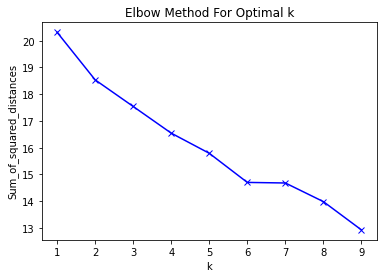

In [30]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(grouped_venues.drop('Suburb', 1))
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()


In [34]:
# set number of clusters
k = 2

# run k-means clustering
kmeans = KMeans(n_clusters=k, random_state=0).fit(grouped_venues.drop('Suburb', 1))

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:100]

# Create dist plot

array([0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1], dtype=int32)

Create a new dataframe that includes the top 10 venues for each neighborhood as well as their clusters.


In [35]:
# add clustering labels
try:
    venues_sorted.insert(0, 'Clus_Kmean', kmeans.labels_)
except:
     venues_sorted.drop(columns='Clus_Kmean', axis=1, inplace=True)
     venues_sorted.insert(0, 'Clus_Kmean', kmeans.labels_)
    
merged = CapeTown_data

# merge CT_grouped with CT_data to add latitude/longitude for each neighborhood
merged = merged.join(venues_sorted.set_index('Suburb'), on='Suburb')
print('Old size: {}'.format(merged.shape))

# Drop NaN and convert cluster to int
merged = merged.dropna(axis = 0).reset_index(drop=True)
merged['Clus_Kmean']= merged['Clus_Kmean'].astype(int)
merged


Old size: (131, 12)


,Suburb,Exurb,gcode,Latitude,Longitude,Closest_WTP,Clus_Kmean,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Bakoven,Atlantic Seaboard,"(Bakoven, Camps Bay, Cape Town, City of Cape T...",-33.960000,18.382778,Kloof Nek (above Camps Bay),1,Hotel,Restaurant,Bed & Breakfast,Beach,Spa
1,Bantry Bay,Atlantic Seaboard,"(Bantry Bay, Cape Town Ward 54, Cape Town, Cit...",-33.928151,18.378970,Kloof Nek (above Camps Bay),1,Hotel,Restaurant,Coffee Shop,Deli / Bodega,Bed & Breakfast
2,Camps Bay,Atlantic Seaboard,"(Camps Bay, Cape Town, City of Cape Town, West...",-33.954774,18.381852,Kloof Nek (above Camps Bay),1,Restaurant,Hotel,Pizza Place,Café,Ice Cream Shop
3,Clifton,Atlantic Seaboard,"(Clifton, Cape Town Ward 54, Cape Town, City o...",-33.935285,18.379070,Kloof Nek (above Camps Bay),0,Beach,Scenic Lookout,Park,Lounge,Hotel
4,Fresnaye,Atlantic Seaboard,"(Fresnaye, Cape Town Ward 54, Cape Town, City ...",-33.925194,18.387743,Kloof Nek (above Camps Bay),1,Restaurant,Grocery Store,Coffee Shop,Hotel,Pizza Place
...,...,...,...,...,...,...,...,...,...,...,...,...
124,Melkbosstrand,Western Suburbs,"(Melkbosstrand, City of Cape Town, Western Cap...",-33.722222,18.445833,Witzand (Atlantis),1,Restaurant,Pizza Place,Breakfast Spot,Café,Beach
125,Montague Gardens,Western Suburbs,"(Montague Gardens, Milnerton, City of Cape Tow...",-33.859750,18.522916,Albion Spring (Newlands),0,Park,Dance Studio,Burger Joint,Pizza Place,Liquor Store
126,Parklands,Western Suburbs,"(Parklands, City of Cape Town, Western Cape, 7...",-33.804562,18.509349,Albion Spring (Newlands),1,Restaurant,Grocery Store,Food Truck,Pizza Place,Bakery
127,Table View,Western Suburbs,"(Table View, Cape Town Ward 107, City of Cape ...",-33.823611,18.490278,Albion Spring (Newlands),1,Restaurant,Burger Joint,Gas Station,Breakfast Spot,Shopping Mall


In [36]:
merged['Clus_Kmean'].value_counts()

1    87
0    42
Name: Clus_Kmean, dtype: int64

In [37]:
# create map
def ClusterMap(df , add , zoom_start, area , k, label = 'Clus_Kmean'):
    
    lati, longi = getCoord(add)
    map_ = folium.Map(location=[lati, longi], zoom_start=zoom_start)
#     map_ = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
    x = np.arange(k)
    ys = [i + x + (i*x)**2 for i in range(k)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster in zip(df['Latitude'], df['Longitude'], df['Suburb'], df[label]):
        label = folium.Popup(str(poi) + ' : Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=6,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.5).add_to(map_)

    return(map_)

In [38]:
ClusterMap(df = merged, add = 'Cape Town', zoom_start = 11, area = 'Suburb', k = k)

### Examine clusters

#### Cluster 1

Red coloured: Outskirts

In [39]:

label = 'Clus_Kmean'
merged.loc[merged[label] == 0, merged.columns[[0] + list(range(4, merged.shape[1]))]]


,Suburb,Longitude,Closest_WTP,Clus_Kmean,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
3,Clifton,18.379070,Kloof Nek (above Camps Bay),0,Beach,Scenic Lookout,Park,Lounge,Hotel
12,Athlone,18.505000,Albion Spring (Newlands),0,Park,Pizza Place,Fried Chicken Joint,Stadium,Bakery
13,Bishop Lavis,18.575833,Albion Spring (Newlands),0,Mattress Store,Fried Chicken Joint,Café,Farm,Food & Drink Shop
16,Crossroads,18.598889,Albion Spring (Newlands),0,Department Store,Deli / Bodega,Home Service,Airport Terminal,Business Service
19,Hanover Park,18.533056,Albion Spring (Newlands),0,Shopping Mall,Factory,Food,Convenience Store,Fried Chicken Joint
21,Khayelitsha,18.667420,Faure (hillside to the north of Faure),0,Shopping Mall,Burger Joint,Convenience Store,Lounge,Coffee Shop
22,Langa,18.530000,Albion Spring (Newlands),0,Clothing Store,Home Service,Luggage Store,Construction & Landscaping,Gym
23,Lavender Hill,18.483333,Albion Spring (Newlands),0,Beach,Zoo,Farm,Food Court,Food & Drink Shop
24,Manenberg,18.554444,Albion Spring (Newlands),0,Shopping Mall,Construction & Landscaping,Grocery Store,Train Station,Gas Station
27,Ottery,18.509153,Albion Spring (Newlands),0,Pharmacy,Train Station,Fabric Shop,Food & Drink Shop,Food


In [40]:
merged.loc[merged[label] == 1, merged.columns[[0] + list(range(4, merged.shape[1]))]]

,Suburb,Longitude,Closest_WTP,Clus_Kmean,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Bakoven,18.382778,Kloof Nek (above Camps Bay),1,Hotel,Restaurant,Bed & Breakfast,Beach,Spa
1,Bantry Bay,18.378970,Kloof Nek (above Camps Bay),1,Hotel,Restaurant,Coffee Shop,Deli / Bodega,Bed & Breakfast
2,Camps Bay,18.381852,Kloof Nek (above Camps Bay),1,Restaurant,Hotel,Pizza Place,Café,Ice Cream Shop
4,Fresnaye,18.387743,Kloof Nek (above Camps Bay),1,Restaurant,Grocery Store,Coffee Shop,Hotel,Pizza Place
5,Green Point,18.405968,Kloof Nek (above Camps Bay),1,Restaurant,Café,Grocery Store,Hotel,Bakery
...,...,...,...,...,...,...,...,...,...
123,Darling,18.422277,Kloof Nek (above Camps Bay),1,Restaurant,Café,Coffee Shop,Hotel,Theater
124,Melkbosstrand,18.445833,Witzand (Atlantis),1,Restaurant,Pizza Place,Breakfast Spot,Café,Beach
126,Parklands,18.509349,Albion Spring (Newlands),1,Restaurant,Grocery Store,Food Truck,Pizza Place,Bakery
127,Table View,18.490278,Albion Spring (Newlands),1,Restaurant,Burger Joint,Gas Station,Breakfast Spot,Shopping Mall


## DBSCAN()

### For Venues

In [41]:
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler


Clus_dataSet = CapeTown_venues[['Venue_Longitude','Venue_Latitude']]
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

# Compute DBSCAN
db = DBSCAN(eps=0.5, min_samples=200).fit(Clus_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
CapeTown_venues["Clus_Db"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 


# A sample of clusters
CapeTown_venues["Clus_Db"].value_counts()

 0    1182
-1     702
Name: Clus_Db, dtype: int64

### Dbscan for Suburbs

In [42]:

Clus_dataSet = merged[['Longitude','Latitude']]
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

# Compute DBSCAN
db = DBSCAN(eps=0.85, min_samples=50).fit(Clus_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
merged["Clus_Db"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 


# A sample of clusters
merged["Clus_Db"].value_counts()
merged

,Suburb,Exurb,gcode,Latitude,Longitude,Closest_WTP,Clus_Kmean,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Clus_Db
0,Bakoven,Atlantic Seaboard,"(Bakoven, Camps Bay, Cape Town, City of Cape T...",-33.960000,18.382778,Kloof Nek (above Camps Bay),1,Hotel,Restaurant,Bed & Breakfast,Beach,Spa,0
1,Bantry Bay,Atlantic Seaboard,"(Bantry Bay, Cape Town Ward 54, Cape Town, Cit...",-33.928151,18.378970,Kloof Nek (above Camps Bay),1,Hotel,Restaurant,Coffee Shop,Deli / Bodega,Bed & Breakfast,0
2,Camps Bay,Atlantic Seaboard,"(Camps Bay, Cape Town, City of Cape Town, West...",-33.954774,18.381852,Kloof Nek (above Camps Bay),1,Restaurant,Hotel,Pizza Place,Café,Ice Cream Shop,0
3,Clifton,Atlantic Seaboard,"(Clifton, Cape Town Ward 54, Cape Town, City o...",-33.935285,18.379070,Kloof Nek (above Camps Bay),0,Beach,Scenic Lookout,Park,Lounge,Hotel,0
4,Fresnaye,Atlantic Seaboard,"(Fresnaye, Cape Town Ward 54, Cape Town, City ...",-33.925194,18.387743,Kloof Nek (above Camps Bay),1,Restaurant,Grocery Store,Coffee Shop,Hotel,Pizza Place,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,Melkbosstrand,Western Suburbs,"(Melkbosstrand, City of Cape Town, Western Cap...",-33.722222,18.445833,Witzand (Atlantis),1,Restaurant,Pizza Place,Breakfast Spot,Café,Beach,-1
125,Montague Gardens,Western Suburbs,"(Montague Gardens, Milnerton, City of Cape Tow...",-33.859750,18.522916,Albion Spring (Newlands),0,Park,Dance Studio,Burger Joint,Pizza Place,Liquor Store,0
126,Parklands,Western Suburbs,"(Parklands, City of Cape Town, Western Cape, 7...",-33.804562,18.509349,Albion Spring (Newlands),1,Restaurant,Grocery Store,Food Truck,Pizza Place,Bakery,-1
127,Table View,Western Suburbs,"(Table View, Cape Town Ward 107, City of Cape ...",-33.823611,18.490278,Albion Spring (Newlands),1,Restaurant,Burger Joint,Gas Station,Breakfast Spot,Shopping Mall,-1


In [46]:
ClusterMap(df = merged, add = 'Cape Town', zoom_start = 11, area = 'Suburb', k = k, label= 'Clus_Db')